In [31]:
import pandas as pd
from fastai.text.all import *
from os.path import exists
import re
import csv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
import sys
import os
from pathlib import Path
from IPython.utils import io
csv.field_size_limit(2147483647)

2147483647

In [32]:
# Training and testing datasets
df_train = pd.read_csv("data/designs-train.csv", sep="‡", engine="python", index_col="id")
df_test = pd.read_csv("data/designs-test.csv", sep="‡", engine="python", index_col="id")

In [33]:
# Constructs dataloaders (dataset arrangement in batches, used for fastai model training)
# Note: If training crashes due to full CUDA memory, decrease the batch size (bs) value; however, this will alter the training results.
# Monitoring GPU usage while training (in terminal): gpustat --watch
def make_dls(df, text_cols):
    with io.capture_output() as captured:
        classifier = DataBlock(blocks=(TextBlock.from_df(text_cols=text_cols), MultiCategoryBlock),
                               n_inp=1,
                               get_x=ColReader('text'),
                               splitter=ColSplitter(col='is_valid'),
                               get_y=ColReader('goals', label_delim=' '))
        dataloaders = classifier.dataloaders(df, bs=512)
    return dataloaders

In [34]:
# Sets all randomization seeds to a specific value for replicable results
def set_seed(dls, x=42):
    random.seed(x)
    dls.rng.seed(x)
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

In [35]:
# Accuracy and loss functions
def goals_accuracy(inp, goals, thresh=0.5, sigmoid=True): 
    if sigmoid:
        inp = inp.sigmoid()
    inp = inp > thresh
    return (torch.logical_and(inp, goals).sum(dim=1) / torch.logical_or(inp, goals).sum(dim=1)).mean()
def goals_loss(inp, goals): return BCEWithLogitsLossFlat()(inp, goals)

In [36]:
# Gets goal probabilities from a model and a given dataset
def get_preds(model, df, text_cols):
    with io.capture_output() as captured:
        df_probs = tokenize_df(df=df, text_cols=text_cols, tok=model.dls.tok)[0]
        dl = model.dls.test_dl(df_probs)
        with model.no_logging(), model.no_bar(): probs, _ = model.get_preds(dl=dl)
        probs = torch.sigmoid(probs)
        return [dict(zip(model.dls.vocab[1], p)) for p in probs]

In [37]:
# Checking accuracy in a specific df
def check_accuracy(model, df, text_cols):
    preds = get_preds(model, df, text_cols)
    x = tensor([list(p.values()) for p in preds])
    v = model.dls.vocab[1]
    y = tensor(np.array([torch.nn.functional.one_hot(tensor(v.map_objs(g.split())), num_classes=len(v)).sum(dim=0).numpy() for g in df["goals"]]))
    return goals_accuracy(x, y, sigmoid=False)

In [38]:
# Reclassifies a part of the dataset based on prediction confidence and trust
def reclassify(model, df, text_cols, p=0.01, t=0.5, rp=0):
    df_t = df.loc[df["is_valid"] == 0].copy()
    
    preds = get_preds(model, df_t, text_cols)
    preds_new = [{k: v for k, v in p.items() if k not in g.split()} for p, g in zip(preds, df_t["goals"])]
    preds_current = [{k: v for k, v in p.items() if k in g.split()} for p, g in zip(preds, df_t["goals"])]
    df_t["count"] = df_t["goals"].map(lambda g: len(g.split()))
    df_t["conf_add"] = [max(p.values())-(rp if df_t.iloc[i]["count"] == 5 else 0) for i, p in enumerate(preds_new)]
    df_t["conf_remove"] = [1-min(p.values())-rp for i, p in enumerate(preds_current)]
    df_t["pred_add"] = [max(p, key=p.get) for p in preds_new]
    df_t["pred_remove"] = [min(p, key=p.get) for p in preds_current]
    df_t["wrong"] = df_t.apply(lambda r: max(r["conf_add"], r["conf_remove"]) > 0.5, axis=1)
    
    df_t['sort_val'] = df_t.apply(lambda r: max(r["conf_add"], r["conf_remove"]) - t * r["trust"], axis=1)
    count = math.ceil(p*len(df_t))
    idx = df_t[df_t["wrong"] == True].sort_values(by=['sort_val'], ascending=False).iloc[0:count].index
    
    def new_goals(r):
        if r["conf_remove"] > r["conf_add"]:
            if r["count"] == 1:
                return r["pred_add"]
            return " ".join([g for g in r["goals"].split() if g != r["pred_remove"]])
        else:
            if r["count"] == 5:
                return " ".join([r["pred_add"] if g == r["pred_remove"] else g for g in r["goals"].split()])
            return r["goals"] + f" {r['pred_add']}"
    df_t.loc[idx, "pred"] = df_t.apply(new_goals, axis=1)
    
    df_new = df.copy()
    changes_log = [""]
    changes_log += [f"changed goals of {i}: {df_new.loc[i, 'goals']} -> {df_t.loc[i, 'pred']} (conf: {max(df_t.loc[i, 'conf_add'], df_t.loc[i, 'conf_remove'])})" for i in idx]
    df_new.loc[idx, "goals"] = df_t.loc[idx, "pred"]
    return df_new, changes_log

In [39]:
# Loads a model if a saved one exists, otherwise trains a new one
def load_or_create(df, path='', text_cols=['long_description', 'page_title', 'page_body', 'meta_title', 'meta_description'], epochs=10, mode=1, delay=2, p=0.01, t=0.5, rp=0):
    torch.cuda.empty_cache()
    # If a saved model exists, load it
    if path and exists(path+f'{mode}model.pkl'):
        return (load_pickle(path + f'{mode}model.pkl'),
                load_pickle(path + f'{mode}metrics.pkl'),
                pd.read_csv(path + f'{mode}data.csv', sep='‡', engine='python', index_col='id'))
    else:
        dls = make_dls(df, text_cols)
        df_new = df.copy()
        set_seed(dls)
        learner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, loss_func=goals_loss, metrics=[goals_accuracy]).to_fp16()
        metrics = []
        changes_log = []
        # Iterative Reclassification
        for i in tqdm(range(epochs)):
            # Training for 1 epoch
            with learner.no_bar(), learner.no_logging():
                learner.fit_one_cycle(1)
            # Tracking metrics: train loss, valid loss, valid accuracy, test accuracy
            metrics.append((learner.recorder.losses[-1],
                            learner.recorder.loss.value,
                            learner.recorder.metrics[0].value,
                            check_accuracy(learner, df_test, text_cols)
                            ))
            # Reclassification
            if mode == 1 and delay <= i:
                df_new, changes = reclassify(learner, df_new, text_cols, t=t, p=p, rp=rp)
                changes_log += changes
                learner.dls = make_dls(df_new, text_cols)
                
        #  Saving the model, metrics and modified dataset
        if path:
            Path(path).mkdir(parents=True, exist_ok=True)
            save_pickle(path + f'{mode}model.pkl', learner)
            save_pickle(path + f'{mode}metrics.pkl', metrics)
            df_new.to_csv(path + f'{mode}data.csv', sep="‡")
            if mode != 0:
                f = open(path + f'{mode}changes.log', 'w')
                for line in changes_log:
                    f.write(f"{line}\n")
                f.close()
        torch.cuda.empty_cache()
        return learner, metrics, df_new


In [40]:
# Comparing the metrics of different models
def plotMetrics(labels, metricsList, delay=0):
    xlabel="epoch"
    ylabels=["training loss", "validation loss", "validation accuracy", "test accuracy"] 
    for col in range(4):
        for i in range(len(labels)):
            plt.plot([x[col] for x in metricsList[i]], label=labels[i])
        plt.ylabel(ylabels[col])
        plt.xlabel(xlabel)
        plt.legend()
        if delay != 0: plt.axvline(x = delay, color = "grey", linestyle=":")
        plt.show()

In [41]:
# Comparing avg and max accuracies
def compareAccuracy(labels, metricsList):
    df_accuracy = pd.DataFrame()
    df_accuracy["model"] = labels
    df_accuracy["max valid accuracy"] = [np.round(max([x[2] for x in metrics]).numpy(), 3) for metrics in metricsList]
    df_accuracy["max test accuracy"] = [np.round(max([x[3] for x in metrics]).numpy(), 3) for metrics in metricsList]
    df_accuracy["max combined accuracy"] = [np.round(max([x[2] + x[3] for x in metrics]).numpy() / 2, 3) for metrics in metricsList]
    return df_accuracy

In [42]:
_, metrics1, df1 = load_or_create(df_train, path="models/ir/goal/1/", text_cols=["long_description"], epochs=100, mode=0)

In [43]:
_, metrics2_005, df2_005 = load_or_create(df_train, path="models/ir/goal/2_005/", text_cols=["long_description"], epochs=50, mode=1, p=0.005, t=0)
_, metrics2_01,  df2_01  = load_or_create(df_train, path="models/ir/goal/2_01/",  text_cols=["long_description"], epochs=50, mode=1, p=0.01,  t=0)
_, metrics3_005, df3_005 = load_or_create(df_train, path="models/ir/goal/3_005/", text_cols=["long_description"], epochs=50, mode=1, p=0.005, t=0.5)
_, metrics3_01,  df3_01  = load_or_create(df_train, path="models/ir/goal/3_01/",  text_cols=["long_description"], epochs=50, mode=1, p=0.01,  t=0.5)
_, metrics6_005, df6_005 = load_or_create(df_train, path="models/ir/goal/6_005/", text_cols=["long_description"], epochs=30, mode=1, p=0.005, t=0,   rp=0.2)
_, metrics6_01,  df6_01  = load_or_create(df_train, path="models/ir/goal/6_01/",  text_cols=["long_description"], epochs=30, mode=1, p=0.01,  t=0,   rp=0.2)
_, metrics6_02,  df6_02  = load_or_create(df_train, path="models/ir/goal/6_02/",  text_cols=["long_description"], epochs=30, mode=1, p=0.02,  t=0,   rp=0.2)
_, metrics7_005, df7_005 = load_or_create(df_train, path="models/ir/goal/7_005/", text_cols=["long_description"], epochs=30, mode=1, p=0.005, t=0.5, rp=0.2)
_, metrics7_01,  df7_01  = load_or_create(df_train, path="models/ir/goal/7_01/",  text_cols=["long_description"], epochs=30, mode=1, p=0.01,  t=0.5, rp=0.2)
_, metrics7_02,  df7_02  = load_or_create(df_train, path="models/ir/goal/7_02/",  text_cols=["long_description"], epochs=30, mode=1, p=0.02,  t=0.5, rp=0.2)

In [44]:
_, metrics4_01, df4_01 = load_or_create(df_train, path="models/ir/goal/4_01/", text_cols=["long_description"], epochs=50, mode=1, delay=15, p=0.01, t=0)
_, metrics5_01, df5_01 = load_or_create(df_train, path="models/ir/goal/5_01/", text_cols=["long_description"], epochs=50, mode=1, delay=15, p=0.01, t=0.5)
_, metrics8_01, df8_01 = load_or_create(df_train, path="models/ir/goal/8_01/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.01, t=0,   rp=0.2)
_, metrics8_02, df8_02 = load_or_create(df_train, path="models/ir/goal/8_02/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.02, t=0,   rp=0.2)
_, metrics8_05, df8_05 = load_or_create(df_train, path="models/ir/goal/8_05/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.05, t=0,   rp=0.2)
_, metrics9_01, df9_01 = load_or_create(df_train, path="models/ir/goal/9_01/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.01, t=0.5, rp=0.2)
_, metrics9_02, df9_02 = load_or_create(df_train, path="models/ir/goal/9_02/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.02, t=0.5, rp=0.2)
_, metrics9_05, df9_05 = load_or_create(df_train, path="models/ir/goal/9_05/", text_cols=["long_description"], epochs=30, mode=1, delay=15, p=0.05, t=0.5, rp=0.2)

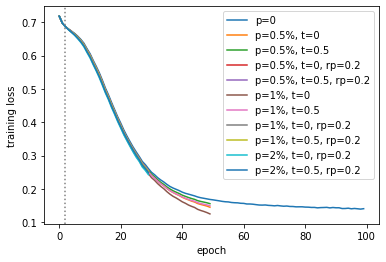

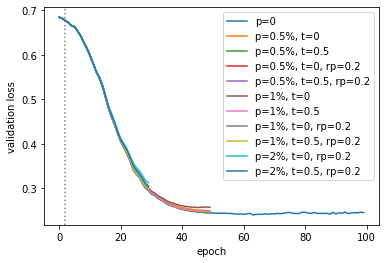

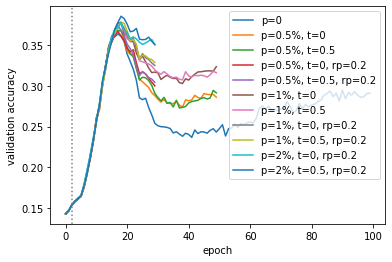

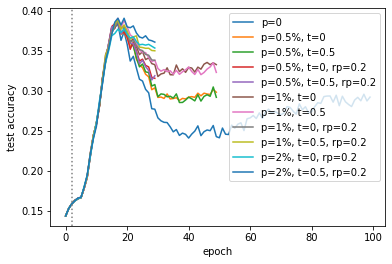

In [45]:
plotMetrics(["p=0", "p=0.5%, t=0", "p=0.5%, t=0.5", "p=0.5%, t=0, rp=0.2", "p=0.5%, t=0.5, rp=0.2", "p=1%, t=0", "p=1%, t=0.5", "p=1%, t=0, rp=0.2", "p=1%, t=0.5, rp=0.2", "p=2%, t=0, rp=0.2", "p=2%, t=0.5, rp=0.2"], 
            [metrics1, metrics2_005, metrics3_005, metrics6_005, metrics7_005, metrics2_01, metrics3_01, metrics6_01, metrics7_01, metrics6_02, metrics7_02], delay=2)

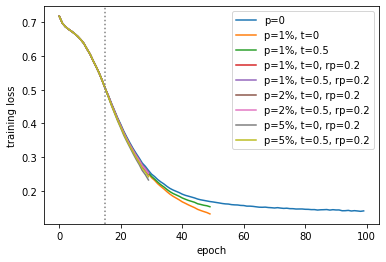

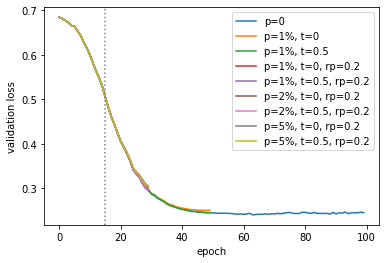

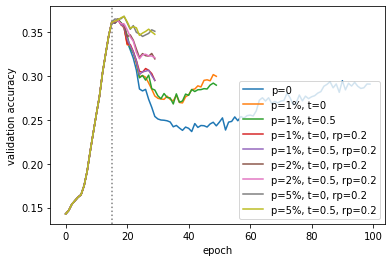

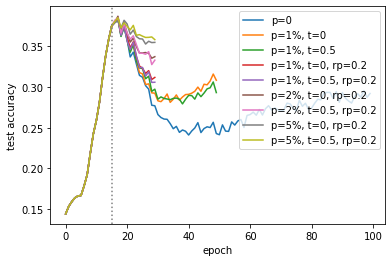

In [46]:
plotMetrics(["p=0", "p=1%, t=0", "p=1%, t=0.5", "p=1%, t=0, rp=0.2", "p=1%, t=0.5, rp=0.2", "p=2%, t=0, rp=0.2", "p=2%, t=0.5, rp=0.2", "p=5%, t=0, rp=0.2", "p=5%, t=0.5, rp=0.2"],
            [metrics1, metrics4_01, metrics5_01, metrics8_01, metrics9_01, metrics8_02, metrics9_02, metrics8_05, metrics9_05], delay=15)

In [47]:
compareAccuracy(["1", "2_005", "2_01", "3_005", "3_01", "4_01", "5_01", "6_005", "6_01", "6_02", "7_005", "7_01", "7_02", "8_01", "8_02", "8_05", "9_01", "9_02", "9_05"],
                [metrics1, metrics2_005, metrics2_01, metrics3_005, metrics3_01, metrics4_01, metrics5_01, metrics6_005, metrics6_01, metrics6_02, metrics7_005, metrics7_01, metrics7_02, metrics8_01, metrics8_02, metrics8_05, metrics9_01, metrics9_02, metrics9_05])

,model,max valid accuracy,max test accuracy,max combined accuracy
0,1,0.364,0.383,0.374
1,2_005,0.368,0.387,0.377
2,2_01,0.377,0.387,0.382
3,3_005,0.368,0.388,0.378
4,3_01,0.377,0.390,0.382
5,4_01,0.365,0.385,0.375
6,5_01,0.365,0.385,0.375
7,6_005,0.367,0.388,0.377
8,6_01,0.377,0.387,0.382
9,6_02,0.378,0.378,0.376


### Web scraping

In [52]:
df_test["long_description"] = ""

In [49]:
_, metrics1_web, _ = load_or_create(df_train, path="models/web/goal/1/", text_cols=["long_description"], epochs=50, mode=0)
_, metrics2_web, _ = load_or_create(df_train, path="models/web/goal/2/", text_cols=["page_title", "page_body", "meta_title", "meta_description"], epochs=50, mode=0)
_, metrics3_web, _ = load_or_create(df_train, path="models/web/goal/3/", text_cols=["long_description", "page_title", "page_body", "meta_title", "meta_description"], epochs=50, mode=0)

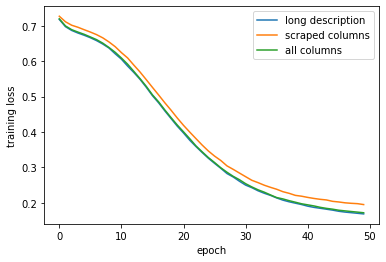

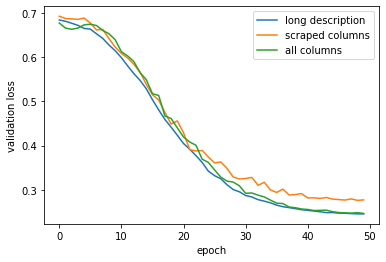

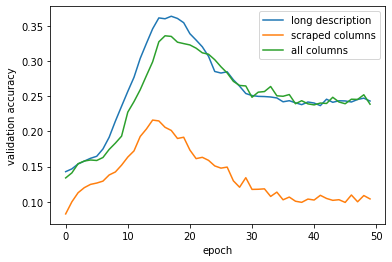

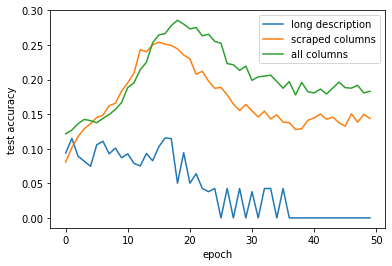

In [50]:
plotMetrics(["long description", "scraped columns", "all columns"], [metrics1_web, metrics2_web, metrics3_web])

In [51]:
compareAccuracy(["long description", "scraped columns", "all columns"], [metrics1_web, metrics2_web, metrics3_web])

,model,max valid accuracy,max test accuracy,max combined accuracy
0,long description,0.364,0.116,0.239
1,scraped columns,0.216,0.254,0.235
2,all columns,0.336,0.286,0.307
